<a href="https://colab.research.google.com/github/s-sridhar24/EVA-S6/blob/master/play_EVA4S6F5_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Session 6 Goals:

Run this model for 40 epochs and plot the Validation Accuracy and Losses in the following configurations:
- Without regularization
- With L1
- With L2
- With L1 and L2

Pick up and display 25 misclassified images for L1 and L2 runs.
 
Present these in github properly

# This file includes L2 regularization on top of mods done to Session 5 File 5.
This notebook uses L2 regularization. Over 40 epochs. The performance of train and test are closer.

Opportunities for improvement includes hyperparameter optimization.

Sum of parameters is displayed to compare with the version without regularization

The difference between train and test accuracy is the key impact targetted.

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       #transforms.RandomAffine(degrees=10, translate=(0.1,0.1), scale=(0.9, 1.1)),
                                       transforms.RandomRotation((-4.0, 4.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       #transforms.Resize((28, 28)),
                                       #transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
#dataloader_args = dict(shuffle=True, batch_size=32, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=32)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# Data Statistics

Same dataset so not important in this step

# The model


In [0]:
import torch.nn.functional as F
dropout_value = 0.03
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=12, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(12),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=12, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(14),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),            
            nn.BatchNorm2d(16),
#            nn.Dropout(dropout_value)
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            #nn.ReLU(),
            #nn.Dropout(dropout_value)
        ) 
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,080
              ReLU-6           [-1, 12, 24, 24]               0
       BatchNorm2d-7           [-1, 12, 24, 24]              24
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 12, 22, 22]           1,296
             ReLU-10           [-1, 12, 22, 22]               0
      BatchNorm2d-11           [-1, 12, 22, 22]              24
          Dropout-12           [-1, 12, 22, 22]               0
        MaxPool2d-13           [-1, 12, 11, 11]               0
           Conv2d-14             [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # L2 regularization
    wd = 5e-5
    w2 = 0
    for p in model.parameters():
      w2 += (p**2).sum()


    # Calculate loss
    loss = F.nll_loss(y_pred, target) + wd*w2

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
  

# Let's Train and test our model

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

EPOCHS = 40
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader) 

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.10108916461467743 Batch_id=468 Accuracy=90.39: 100%|██████████| 469/469 [00:14<00:00, 32.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0812, Accuracy: 9761/10000 (97.61%)

EPOCH: 1


Loss=0.04979848116636276 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:14<00:00, 33.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9851/10000 (98.51%)

EPOCH: 2


Loss=0.05460945889353752 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:14<00:00, 33.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9895/10000 (98.95%)

EPOCH: 3


Loss=0.12221040576696396 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9911/10000 (99.11%)

EPOCH: 4


Loss=0.049593035131692886 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9926/10000 (99.26%)

EPOCH: 5


Loss=0.039124272763729095 Batch_id=468 Accuracy=98.99: 100%|██████████| 469/469 [00:14<00:00, 39.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9926/10000 (99.26%)

EPOCH: 6


Loss=0.03946257755160332 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:14<00:00, 32.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0234, Accuracy: 9936/10000 (99.36%)

EPOCH: 7


Loss=0.029081210494041443 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:14<00:00, 31.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9930/10000 (99.30%)

EPOCH: 8


Loss=0.055419132113456726 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.04652567207813263 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.016407739371061325 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9927/10000 (99.27%)

EPOCH: 11


Loss=0.019264236092567444 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:14<00:00, 32.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9932/10000 (99.32%)

EPOCH: 12


Loss=0.0388282835483551 Batch_id=468 Accuracy=99.34: 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9929/10000 (99.29%)

EPOCH: 13


Loss=0.021292563527822495 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:14<00:00, 32.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99.38%)

EPOCH: 14


Loss=0.0521245039999485 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:14<00:00, 32.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9933/10000 (99.33%)

EPOCH: 15


Loss=0.06844471395015717 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:14<00:00, 41.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.016707679256796837 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9931/10000 (99.31%)

EPOCH: 17


Loss=0.020660819485783577 Batch_id=468 Accuracy=99.39: 100%|██████████| 469/469 [00:14<00:00, 33.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0198, Accuracy: 9938/10000 (99.38%)

EPOCH: 18


Loss=0.02682705968618393 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:14<00:00, 32.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Accuracy: 9943/10000 (99.43%)

EPOCH: 19


Loss=0.045636408030986786 Batch_id=468 Accuracy=99.44: 100%|██████████| 469/469 [00:14<00:00, 32.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

EPOCH: 20


Loss=0.013789670541882515 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9923/10000 (99.23%)

EPOCH: 21


Loss=0.09869641065597534 Batch_id=468 Accuracy=99.45: 100%|██████████| 469/469 [00:14<00:00, 33.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

EPOCH: 22


Loss=0.047510743141174316 Batch_id=468 Accuracy=99.46: 100%|██████████| 469/469 [00:14<00:00, 32.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9936/10000 (99.36%)

EPOCH: 23


Loss=0.037364695221185684 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:14<00:00, 32.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0183, Accuracy: 9945/10000 (99.45%)

EPOCH: 24


Loss=0.06903067231178284 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9943/10000 (99.43%)

EPOCH: 25


Loss=0.02017119713127613 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Accuracy: 9940/10000 (99.40%)

EPOCH: 26


Loss=0.02224111184477806 Batch_id=468 Accuracy=99.48: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9930/10000 (99.30%)

EPOCH: 27


Loss=0.013614274561405182 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:14<00:00, 33.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0199, Accuracy: 9937/10000 (99.37%)

EPOCH: 28


Loss=0.013422181829810143 Batch_id=468 Accuracy=99.53: 100%|██████████| 469/469 [00:14<00:00, 33.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9947/10000 (99.47%)

EPOCH: 29


Loss=0.018916448578238487 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:14<00:00, 31.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)

EPOCH: 30


Loss=0.06584186851978302 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:15<00:00, 31.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9930/10000 (99.30%)

EPOCH: 31


Loss=0.015473849140107632 Batch_id=468 Accuracy=99.56: 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 9947/10000 (99.47%)

EPOCH: 32


Loss=0.018344921991229057 Batch_id=468 Accuracy=99.57: 100%|██████████| 469/469 [00:14<00:00, 33.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9940/10000 (99.40%)

EPOCH: 33


Loss=0.04798004403710365 Batch_id=468 Accuracy=99.52: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9938/10000 (99.38%)

EPOCH: 34


Loss=0.03372165188193321 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:14<00:00, 31.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9947/10000 (99.47%)

EPOCH: 35


Loss=0.01350338663905859 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:13<00:00, 33.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9942/10000 (99.42%)

EPOCH: 36


Loss=0.013559813611209393 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:14<00:00, 33.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0188, Accuracy: 9940/10000 (99.40%)

EPOCH: 37


Loss=0.013600943610072136 Batch_id=468 Accuracy=99.60: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9949/10000 (99.49%)

EPOCH: 38


Loss=0.019029902294278145 Batch_id=468 Accuracy=99.63: 100%|██████████| 469/469 [00:14<00:00, 33.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9944/10000 (99.44%)

EPOCH: 39


Loss=0.028151527047157288 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:14<00:00, 39.77it/s]



Test set: Average loss: 0.0208, Accuracy: 9939/10000 (99.39%)



In [9]:
def model_params_sum(model):
    param_sum = 0
    for p in model.parameters():
      param_sum += torch.sum(abs(p))
      return param_sum

print("The sum of parameters in this model:", model_params_sum(model))

The sum of parameters in this model: tensor(17.4777, device='cuda:0', grad_fn=<AddBackward0>)


Text(0.5, 1.0, 'Test Accuracy')

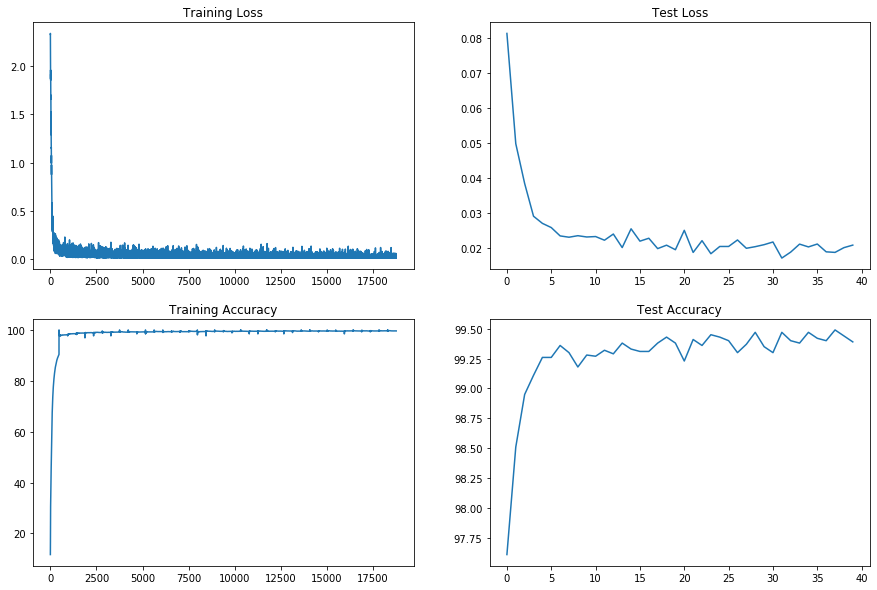

In [10]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# This part deals with identifying and displaying the misclassified images.

Given 10K test dataset, 99.4% accuracy there are 0.6% i.e. 60 images that are misclassified.
Create a new dataloaded with all test data.
In the output, compare target with pred and identify the misclassified images.
Display them as a grid.

In [11]:
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=test_transforms)
valloader = torch.utils.data.DataLoader(valset, batch_size=10000, shuffle=True)


Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



Extracting PATH_TO_STORE_TESTSET/MNIST/raw/train-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-images-idx3-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw



Extracting PATH_TO_STORE_TESTSET/MNIST/raw/t10k-labels-idx1-ubyte.gz to PATH_TO_STORE_TESTSET/MNIST/raw
Processing...
Done!


torch.Size([10000, 1, 28, 28])
torch.Size([10000])


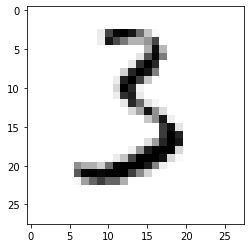

In [12]:
dataiter = iter(valloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r');

In [0]:
# run test with the new dataloader and return the pred, labal and data
def test6(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            return data.detach().cpu().clone().numpy(), pred.detach().cpu().clone().numpy(), target.detach().cpu().clone().numpy()


In [0]:
data, pred, target = test6(model,device,valloader)

In [15]:
print(data.shape)
print(pred.shape)
print(target.shape)

(10000, 1, 28, 28)
(10000, 1)
(10000,)


In [16]:
pred[:,0].shape

(10000,)

In [17]:
misclassified = pred[:,0] != target
misclassified.shape
#data[misclassified].shape
#pred[misclassified,0].shape
#target[misclassified].shape
data[misclassified].shape[0] # this is the count of misclassified images

61

In [0]:
# prepare the subset to display
theFigs = data[misclassified][0:25]
thePreds = pred[misclassified,0][0:25]
theLbls = target[misclassified][0:25]


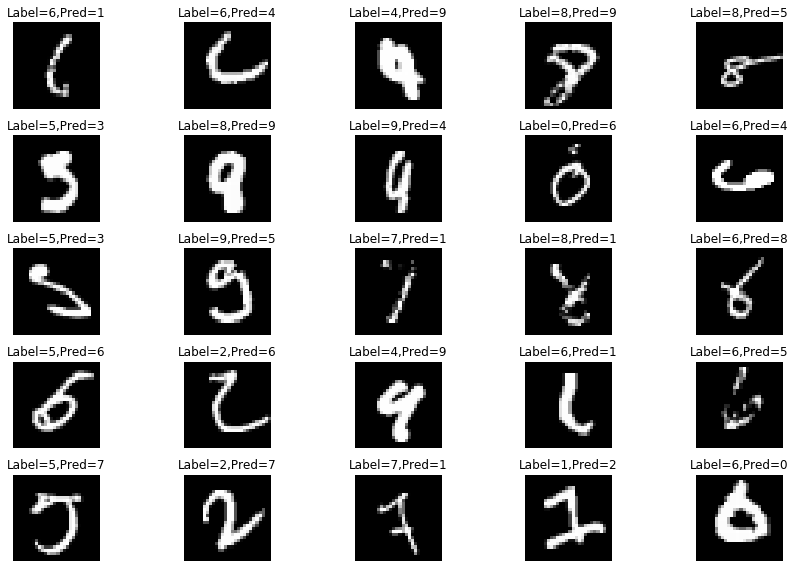

In [19]:
# improvised the snippet from https://corochann.com/mnist-dataset-introduction-1138.html
import chainer
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
 
ROW = 5
COLUMN = 5
for i in range(ROW * COLUMN):
    plt.figsize=(20,20)
    plt.subplot(ROW, COLUMN, i+1)          # subplot with size (width 3, height 5)
    plt.imshow(theFigs[i][0], cmap='gray') # cmap='gray' is for black and white picture.
    plt.title('Label={},Pred={}'.format(theLbls[i],thePreds[i]))
    plt.axis('off')  # do not show axis value
plt.tight_layout(rect=(0,0,2,2))   # tweak padding between subplots
plt.show()

# End of file